## define potential
j'ai enlevé le cas xi faudra réflechir a peut etre le laisser en option

In [1]:
import mpmath as mp
from mpmath import *
import numpy as np
import pandas as pd
import time

mphi_tree = lambda phi, mphigut : mphigut
lambda6_tree = lambda phi, lambda6gut : lambda6gut
A6_tree = lambda phi, mphigut : A6gut

g1 = lambda phi : g1gut/(mp.sqrt(1-pre*b1*g1gut**2*mp.log(phi/phigut)))
g2 = lambda phi : g2gut/(mp.sqrt(1-pre*b2*g2gut**2*mp.log(phi/phigut)))
g3 = lambda phi : g3gut/(mp.sqrt(1-pre*b3*g3gut**2*mp.log(phi/phigut)))

M1 = lambda phi : m1gut*(g1(phi)/g1gut)**mp.mpf('2')
M2 = lambda phi : m2gut*(g2(phi)/g2gut)**mp.mpf('2')
M3 = lambda phi : m3gut*(g3(phi)/g3gut)**mp.mpf('2')

mphi_lle = lambda phi, mphigut : mp.sqrt(mphigut**2+(m2gut**2-M2(phi)**2)+mp.mpf('1')/11*(m1gut**2-M1(phi)**2))
A6_lle = lambda phi, A6gut : A6gut-mp.mpf('6')*(m2gut-M2(phi))-mp.mpf('6')/11*(m1gut-M1(phi))
lambda6_lle = lambda phi, lambda6gut : lambda6gut*(g2gut/g2(phi))**mp.mpf('6')*(g1gut/g1(phi))**(mp.mpf('6')/11)

mphi_udd = lambda phi, mphigut : mp.sqrt(mphigut**2-mp.mpf('8')/9*(m3gut**2-M3(phi)**2)+mp.mpf('4')/99*(m1gut**2-M1(phi)**2))
A6_udd = lambda phi, A6gut : A6gut+mp.mpf('16')/3*(m3gut-M3(phi))-mp.mpf('8')/33*(m1gut-M1(phi))
lambda6_udd = lambda phi, lambda6gut : lambda6gut*(g3gut/g3(phi))**(mp.mpf('-16')/3)*(g1gut/g1(phi))**(mp.mpf('8')/33)

def V_MSSM(phi, infl_type, mphigut, A6gut, lambda6gut):
    if infl_type == 0 or infl_type == 'tree':
        mphi_func, A6_func, lambda6_func = mphi_tree, A6_tree, lambda6_tree
    elif infl_type == 1 or infl_type == 'lle':
        mphi_func, A6_func, lambda6_func = mphi_lle, A6_lle, lambda6_lle
    elif infl_type == 2 or infl_type == 'udd':
        mphi_func, A6_func, lambda6_func = mphi_udd, A6_udd, lambda6_udd
    else:
        return 'Error: unknown type of inflation'
    lambda6 = lambda6_func(phi, lambda6gut)
    mphi = mphi_func(phi,mphigut)
    A6 = A6_func(phi,A6gut)
    V = mp.mpf('0.5')*mphi**mp.mpf('2')*phi**mp.mpf('2')-lambda6*A6/(mp.mpf('6')*Mp**mp.mpf('3'))*phi**mp.mpf('6')+lambda6**mp.mpf('2')*phi**mp.mpf('10')/Mp**mp.mpf('6')
    return V


## compute phi*, As, ns


In [2]:

def DV(V,phi):
    return mp.diff(V, phi, addprec=addprec_deriv)

def D2V(V, phi):
    return mp.diff(V, phi, 2, addprec=addprec_deriv)
def eps1_(V, phi):
    return Mp**2/2*(DV(V,phi)/V(phi))**2

def eps2_(V, phi):
    return 2*Mp**2*((DV(V,phi)/V(phi))**2-D2V(V,phi)/V(phi))

def N_low(V, phimin, phimax):
    integ = mp.quad(lambda phi : V(phi)/DV(V, phi), [phimin, phimax], verbose=False, method='tanh-sinh')
#     print(nstr(-integ/Mp**2, 20), end=', ')
    return -integ/Mp**2

def find_phi_st(V, phi, phi_end, Pstar, lnRrad):
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = log(kstar) - lnMpcToKappa - 0.5*log(HubbleSquareRootOf3OmegaRad) -mp.mpf('0.25')*log(RelatDofRatio)
    Delta_N_star = N_low(V, phi, phi_end)
    return -Delta_N_star + lnRrad - N0 - 0.25*mp.log(9/eps1_(V, phi)/(3-eps1_(V, phi_end))*V(phi_end)/V(phi))+0.25*mp.log(8*mp.pi**2*Pstar)

def endinf(V, start):
    return mp.findroot(lambda phi: eps1_(V, phi)-1, 0.95*start)

def phi_star(V, Pstar, lnRrad, phi_single, plotose=False):
#     print('decimal prec of computations :', mp.dps)
    phi_start = mp.findroot(lambda phi : D2V(V, phi), phi_single)
    phi_end = endinf(V, phi_start*0.98)
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = log(kstar) - lnMpcToKappa - 0.5*log(HubbleSquareRootOf3OmegaRad) -mp.mpf('0.25')*log(RelatDofRatio)
    if plotose == True:
        mp.plot([lambda phi : N_low(V, phi, phi_end), lambda phi : lnRrad - N0 - 0.25*mp.log(9/eps1_(V, phi)/(3-eps1_(V, phi_end))*V(phi_end)/V(phi))+0.25*mp.log(8*mp.pi**2*Pstar)], xlim = (phi_start*(1-shift_plot),phi_start*(1+shift_plot)), points=20)
    #     mp.plot([lambda phi : N_low(V, phi, phi_end),lambda phi : N(V, phi, phi_end), lambda phi : lnRrad - N0 - 0.25*mp.log(9/eps1_(V, phi)/(3-eps1_(V, phi_end))*V(phi_end)/V(phi))+0.25*mp.log(8*mp.pi**2*Pstar)], xlim = (8028264255854228,8028264255874228), points=20)
        mp.plot([lambda phi : eps2_(V, phi)], xlim = (phi_start*(1-shift_plot),phi_start*(1+shift_plot)), points=100)
    start_time = time.process_time()
    phi_star = mp.findroot(lambda phi : find_phi_st(V, phi, phi_end, Pstar, lnRrad), x0 = (phi_start-10,phi_start+10), verbose = False, method='ridder')
    print(int(time.process_time()-start_time),end='s ')
    return phi_star

def ns_(V, phi):
    return mp.fsub(mp.fsub(1,2*eps1_(V, phi)),eps2_(V, phi))

def P_star(V, phi_sta):
    Vstar = V(phi_sta)
    eps1star = eps1_(V, phi_sta)
    return Vstar/(Mp**4*24*mp.pi**2*eps1star)




Find the intersection (ie phi*, As, ns)



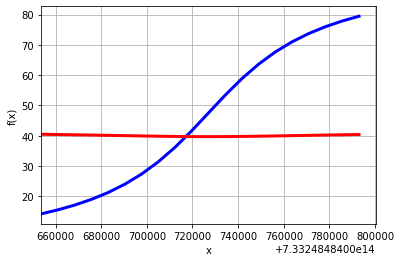

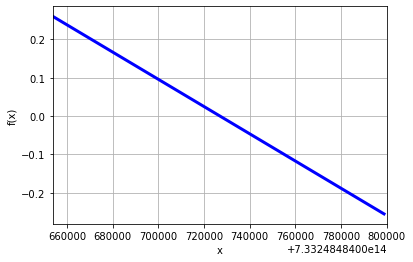

9s 
ns = 0.96530000214
As = 2.09900688683e-9


In [3]:
dps_def = 15
mp.dps = dps_def

extradps_def = 20
addprec_deriv = 25

shift_plot = 1e-10

    
with extradps(extradps_def):
    lnMpinGev = mp.mpf('42.334')
    Mp = mp.exp(lnMpinGev)
    phigut = mp.mpf('3e16')
    pre = mp.mpf('1')/(mp.mpf('8')*mp.pi**2)
    b1, b2, b3 = mp.mpf('33')/mp.mpf('5'), mp.mpf('1'), mp.mpf('-3')
    g1gut = mp.sqrt(mp.mpf('5')/mp.mpf('3'))*mp.mpf('5.45185741e-01')
    g2gut = mp.mpf('6.90473022e-01')
    g3gut = mp.mpf('6.84972506e-01')
    m1gut = mp.mpf('1.36108022e+02')
    m2gut = mp.mpf('1.14286222e+03')
    m3gut = mp.mpf('8.98639714e+02')
    phi0 = mp.mpf('733248484726943.0')
    mphi = mp.mpf('4209.792914467206175046020213939783753565158332962')
    A6 = mp.mpf('26864.51288906253865875539898989172939364528742875')
    lambda6 = mp.mpf('0.05966707808732239059466026395829745169066587954642')
    V = lambda phi : V_MSSM(phi, 'lle', mphi, A6, lambda6)

print('Find the intersection (ie phi*, As, ns)\n')

phi_sta = phi_star(V, mp.mpf('2.0989031673191437e-9'), mp.mpf('0'), phi0, plotose=True)
ns_star = ns_(V, phi_sta)
P_sta = P_star(V, phi_sta)
print('\nns =',nstr(ns_star, 12))
print('As =',nstr(P_sta, 12))


## To deduce analytically FI (lle case only!)

In [4]:
mphi_run = lambda phi_start, phi_end, mphi_start : mp.sqrt(mphi_start**2+(M2(phi_start)**2-M2(phi_end)**2)+mp.mpf('1')/11*(M1(phi_start)**2-M1(phi_end)**2))
lambda6_run = lambda phi_start, phi_end, lambda6_start : lambda6_start*(g2(phi_start)/g2(phi_end))**mp.mpf('6')*(g1(phi_start)/g1(phi_end))**(mp.mpf('6')/11)

with extradps(extradps_def):
    B1=b1/(16*mp.pi**2)
    B2=b2/(16*mp.pi**2)
    C1=2*B1
    C2=2*B2
    e1=mp.mpf('1')/mp.mpf('11')*b1/(4*mp.pi**2) 
    e2=b2/(mp.mpf('4')*mp.pi**2)
    F1=3*e1
    F2=3*e2
    D1=F1/2
    D2=F2/2

def betag1(phi):
    return 2*B1*g1(phi)**4
def betag2(phi):
    return 2*B2*g2(phi)**4
def betaM1(phi):
    return C1*g1(phi)**2*M1(phi)
def betaM2(phi):
    return C2*g2(phi)**2*M2(phi)
def betam(phi):
    return -e1*g1(phi)**2*M1(phi)**2-e2*g2(phi)**2*M2(phi)**2
def betaA(phi):
    return F1*g1(phi)**2*M1(phi)+F2*g2(phi)**2*M2(phi)
def betalambda(phi):
    return -(D1*g1(phi)**2+D2*g2(phi)**2)
def CST1p(phi, dv):
    return 2*dv/phi-betam(phi)
def CST2p(phi):
    return -2*((B1+C1)*e1*M1(phi)**2*g1(phi)**4+(B2+C2)*e2*M2(phi)**2*g2(phi)**4)+3*betam(phi)
def c1(phi):
    return -12*(5+betalambda(phi))
def c2(phi):
    return -12*(D1*betag1(phi)+D2*betag2(phi)-(5+betalambda(phi))*(9+2*betalambda(phi)))
def c3(phi, A6gut):
    return betaA(phi)+A6_lle(phi, A6gut)*(6+betalambda(phi))
def c4(phi, A6gut):
    return -(2*B1+C1)*F1*M1(phi)*g1(phi)**4-(2*B2+C2)*F2*M2(phi)*g2(phi)**4-betaA(phi)*(mp.mpf('11')+2*betalambda(phi))+A6_lle(phi, A6gut)*(D1*betag1(phi)+D2*betag2(phi)-(5+betalambda(phi))*(6+betalambda(phi)))
def COEF1(phi, A6gut, dv):
    return 3*(CST2p(phi)*c1(phi) - CST1p(phi, dv)*c2(phi))**2 + (CST2p(phi)*c3(phi, A6gut) - CST1p(phi, dv)*c4(phi, A6gut))*(c2(phi)*c3(phi, A6gut) - c1(phi)*c4(phi, A6gut))
def COEF2(phi, A6gut, dv):
    return 2*(6*(c1(phi) + c2(phi))*(CST2p(phi)*c1(phi) - CST1p(phi, dv)*c2(phi)) + (c3(phi, A6gut) + c4(phi, A6gut))*(c2(phi)*c3(phi, A6gut) - c1(phi)*c4(phi, A6gut)))
def COEF3(phi):
    return 12*(c1(phi) + c2(phi))**2
def mphi_FI(phi, A6gut, dv):
    Gilbert_res = mp.sqrt((-COEF2(phi, A6gut, dv) + mp.sqrt(COEF2(phi, A6gut, dv)**2-4*COEF1(phi, A6gut, dv)*COEF3(phi)))/(2*COEF3(phi)))
    return Gilbert_res
def lambda6_FI(phi, A6gut, dv):
    return 3*Mp**3/phi**4*(CST2p(phi)*c1(phi) - CST1p(phi, dv)*c2(phi) + 2*mphi_FI(phi, A6gut, dv)**2*(c1(phi) + c2(phi)))/(c2(phi)*c3(phi, A6gut) - c1(phi)*c4(phi, A6gut))

def V(phi, phi0, A6gut, dv):
    mphi_FI_phi0, lambda6_FI_phi0 = mphi_FI(phi0, A6gut, dv), lambda6_FI(phi0, A6gut, dv)
    mphi_FI_gut, lambda6_FI_gut = mphi_run(phi0, phigut, mphi_FI_phi0), lambda6_run(phi0, phigut, lambda6_FI_phi0)
    return 1/2*mphi_lle(phi, mphi_FI_gut)**2*phi**2-A6_lle(phi, A6gut)*lambda6_lle(phi, lambda6_FI_gut)*phi**6/(6*Mp**3)+lambda6_lle(phi, lambda6_FI_gut)**2/Mp**6*phi**10


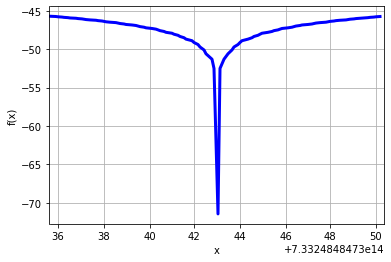

In [5]:
with extradps(extradps_def):
    VFI = lambda phi : V(phi, phi0, A6, mp.mpf('0'))
    mp.plot(lambda phi : mp.log10(eps1_(VFI, phi)), xlim=(0.99999999999999*phi0, phi0*1.00000000000001), points=100)


## Tree

In [6]:
def norm_potential(x,alpha,phi0):
    return x**mp.mpf('2')-mp.mpf('2')/3*alpha*x**6+alpha/mp.mpf('5')*x**10

def norm_eps1(x,alpha,phi0):
    return mp.mpf('450')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**4))**2/((phi0*x)**mp.mpf('2')*(mp.mpf('15')+alpha*x**4*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)

def norm_eps2(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('15')+alpha*x**mp.mpf('4')*(mp.mpf('40')+x**mp.mpf('4')*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/(phi0**2*x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)
       
def norm_eps3(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**mp.mpf('4')))*(mp.mpf('225')+alpha*x**mp.mpf('4')*(-mp.mpf('1350')+x**4*(mp.mpf('3915')+alpha*(-mp.mpf('2100')+mp.mpf('20')*(mp.mpf('81')-mp.mpf('10')*alpha)*x**4+mp.mpf('15')*(-mp.mpf('99')+mp.mpf('20')*alpha)*x**mp.mpf('8')+mp.mpf('90')*alpha*x**mp.mpf('12')+mp.mpf('9')*alpha*x**16)))))/(x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2*(mp.mpf('15')+alpha*x**4*(mp.mpf('40')+x**4*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/phi0**2

def x_endinf(alpha,phi0):
    xstart = mp.mpf('0.9841521')
    return mp.findroot(lambda x : norm_eps1(x,alpha,phi0)-mp.mpf('1'), xstart, solver='halley', verbose = False)

def efold_primitive(x,alpha,phi0):
    aplus=-alpha+mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    aminus=-alpha-mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    bplus=mp.mpf('2')*(aplus+alpha/mp.mpf('3'))/(aplus-aminus)
    bminus=mp.mpf('2')*(aminus+alpha/mp.mpf('3'))/(aminus-aplus)
    return phi0**2*(mp.re(x**2/20+bplus/(10*mp.sqrt(aplus))*mp.atan(mp.sqrt(aplus)*x**2)+bminus/(10*mp.sqrt(aminus))*mp.atan(mp.sqrt(aminus)*x**2)))

def get_calfconst_rrad(lnRrad,Pstar,epsEnd,potEnd):
    cmbMeasuredQuart = mp.mpf('0.25')*mp.log(Pstar*mp.mpf('8')*mp.pi**2)
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = mp.log(kstar) - lnMpcToKappa - mp.mpf('0.5')*mp.log(HubbleSquareRootOf3OmegaRad) - mp.mpf('0.25')*mp.log(RelatDofRatio)
    return - N0 + cmbMeasuredQuart-mp.mpf('0.25')*mp.log(potEnd/(mp.mpf('3')-epsEnd)) + lnRrad

def x_rrad(alpha,phi0,lnRrad,Pstar):
    xEnd = x_endinf(alpha,phi0)
    epsOneEnd = norm_eps1(xEnd,alpha,phi0)
    potEnd = norm_potential(xEnd,alpha,phi0)
    primEnd = efold_primitive(xEnd,alpha,phi0)
    calF = get_calfconst_rrad(lnRrad,Pstar,epsOneEnd,potEnd)
    calFplusNuEnd = calF+primEnd
    x_eps10 = 1
    return mp.findroot(lambda x : find_x_rrad(x, alpha, phi0,calFplusNuEnd), mp.mpf('1'), solver='halley', verbose = False)

def find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar):
    return nuStar - calFplusNuEnd + mp.mpf('0.25')*mp.log(mp.mpf('9')/(epsOneStar*Vstar))

def find_x_rrad(x,alpha,phi0,calFplusNuEnd):
    nuStar = efold_primitive(x,alpha,phi0)
    epsOneStar = norm_eps1(x,alpha,phi0)
    Vstar = norm_potential(x,alpha,phi0)
    res = find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar)
    return res

def ns_from_alpha(alpha, phi0B, lnRrad, Pstar):
    phi0 = phi0B*((5*alpha+mp.sqrt(mp.mpf('25')*alpha**2-mp.mpf('9')))/(9*alpha))**(-mp.mpf('0.25'))
    xstar = x_rrad(alpha, phi0, lnRrad, Pstar)
    return mp.mpf('1')-2*norm_eps1(xstar, alpha, phi0)-norm_eps2(xstar, alpha, phi0)

def alpha_coeff(phi0_B,lnRrad):
    phi0_B_Vec=[0.000001,0.000003,0.00001,0.0001,0.001,0.01,0.1]
    if lnRrad == 0:
      coeff_Vec=[2.5,2.2,2.05,1.7,1.4,1.2,1.]
    elif lnRrad == -10:
      coeff_Vec=[5.2,4.4,3.8,3.,2.4,2.,1.6]
    i=0
    while(phi0_B > phi0_B_Vec[i] and i < 5):
        i=i+1
    i = i-1
    return coeff_Vec[i]+(coeff_Vec[i+1]-coeff_Vec[i])*mp.log(phi0_B/phi0_B_Vec[i])/mp.log(phi0_B_Vec[i+1]/phi0_B_Vec[i])

def alpha_from_phi0B_and_ns(phi0B, ns, lnRrad,Pstar):
    alpha_min = mp.mpf('1')-alpha_coeff(phi0B,lnRrad)*phi0B**4*mp.pi**2/(mp.mpf('900')*mp.mpf('50')**2)
    alpha_max = mp.fsub(mp.mpf('1'),mp.mpf('1e-30'))
    return mp.findroot(lambda alpha : ns_from_alpha(alpha, phi0B, lnRrad, Pstar)-ns, (alpha_min, alpha_max), solver='anderson', verbose=False)

def aspic(lnRrad, ns_f, phi0_input, Pstar):
    with extradps(30):

        phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list, eps10_list = [], [], [], [], [], [], [], [], [], []
        nphi0 = len(phi0_input)
        for i, phi0B in enumerate(phi0_input):

            alpha = alpha_from_phi0B_and_ns(phi0B/Mp, ns_f, lnRrad, Pstar)
            phi0 = phi0B*((5*alpha+mp.sqrt(mp.mpf('25')*alpha**2-mp.mpf('9')))/(9*alpha))**(-mp.mpf('0.25'))
            eps10 = norm_eps1(mp.mpf('1'),alpha,phi0/Mp)
            xstar = x_rrad(alpha, phi0/Mp, lnRrad, Pstar)
            eps1 = norm_eps1(xstar,alpha,phi0/Mp)
            eps2 = norm_eps2(xstar,alpha,phi0/Mp)
            eps3 = norm_eps3(xstar,alpha,phi0/Mp)

            ns, r, alpha_s = 1 - 2*eps1 - eps2, 16*eps1, -2*eps1*eps2-eps2*eps3
            M = (Pstar * 8 * mp.pi**2 * Mp**2 * eps1 * 3 * Mp**2 / norm_potential(xstar,alpha,phi0/Mp))**mp.mpf('0.25')
            mphiBoehm2 = 2 * M**4 / (phi0)**2 
            AB=mp.sqrt(80*alpha)*M**2/(phi0)
            lambdaB=Mp**3*mp.sqrt(alpha/5)*M**2/(phi0)**5

            phi0B_list.append(phi0B)
            phistar_list.append(xstar*phi0)
            alpha_list.append(alpha)
            mphi_list.append(mphiBoehm2**0.5)
            A6_list.append(AB)
            lambda6_list.append(lambdaB)
            ns_list.append(ns)
            r_list.append(r)
            alphas_list.append(alpha_s)
            eps10_list.append(eps10)

        return phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list, eps10_list


## To iterate on phi*

In [7]:
def find_dv(A6gut, phi0, dv, key): 
    mphi_FI_phi0, lambda6_FI_phi0 = mphi_FI(phi0, A6gut, dv), lambda6_FI(phi0, A6gut, dv)
    mphi_FI_gut, lambda6_FI_gut = mphi_run(phi0, phigut, mphi_FI_phi0), lambda6_run(phi0, phigut, lambda6_FI_phi0)
    V_ = lambda phi : V_MSSM(phi, 'lle', mphi_FI_gut, A6gut, lambda6_FI_gut)
#     start = time.process_time()
    phi_sta = phi_star(V_, mp.mpf('2.0989031673191437e-9'), mp.mpf('0'), phi0)
#     global timz
#     timz = time.process_time()-start
#     print(end='.')
    global ns_star, P_sta, phi_sta_stock
    phi_sta_stock = phi_sta
    ns_star = ns_(V_, phi_sta)
    print(nstr(ns_star, 7), end = ', ')
    P_sta = P_star(V_, phi_sta)
    return ns_star

def dv_ns(A6gut, phi0, ns, key='A6'):
#     print('decimal prec of computations 2 :', mp.dps)
    dv_start = mp.sqrt(2*aspic(mp.mpf('0'), ns, [phi0], mp.mpf('2.0989031673191437e-9'))[-1][0]*V(phi0, phi0, A6gut, mp.mpf('0'))**2/Mp**2)
    t = time.process_time()
    dv_ns_res = mp.findroot(lambda dv : find_dv(A6gut, phi0, dv, key) - ns, method='ridder', x0 = (dv_start*0.99, dv_start*1.01), tol=1e-6, verbose=False)
#     mphi_FI_phi0, lambda6_FI_phi0 = mphi_FI(phi0, A6gut, dv_ns_res), lambda6_FI(phi0, A6gut, dv_ns_res)
#     mphi_FI_gut, lambda6_FI_gut = mphi_run(phi0, phigut, mphi_FI_phi0), lambda6_run(phi0, phigut, lambda6_FI_phi0)
#     V_ = lambda phi : V_MSSM(phi, 'lle', mphi_FI_gut, A6gut, lambda6_FI_gut)
#     phi_sta = phi_star(V_, mp.mpf('2.0989031673191437e-9'), mp.mpf('0'), phi0)
#     P_sta = P_star(V_, phi_sta)
    global A6_stock, phi0_stock, dv_stock
    A6_stock, phi0_stock, dv_stock = A6gut, phi0, dv_ns_res
    print('     ', int(time.process_time()-t),'s', nstr(P_sta, 5))
    return P_sta

def A6_start(phi0, As, ns):
    A6_start_start = mp.mpf('10000') # should be robust                      # udd       ! care here !
    Vphi0 = lambda A6gut : 1/2*mphi_FI(phi0, A6gut, mp.mpf('0'))**2*phi0**2-A6_lle(phi0, A6gut)*lambda6_FI(phi0, A6gut, mp.mpf('0'))*phi0**6/(6*Mp**3)+lambda6_FI(phi0, A6gut, mp.mpf('0'))**2/Mp**6*phi0**10
    eps1starphi0 = lambda A6gut : aspic(mp.mpf('0'), ns, [phi0], As)[7][0]/16
    A6_start_ = mp.findroot(lambda A6gut : Vphi0(A6gut)/(24*mp.pi**2*eps1starphi0(A6gut)*As*Mp**4)-1, x0 = (A6_start_start*0.9, A6_start_start*1.1), method='ridder', tol=1e-4, verbose=False)
#     print('□')
    return A6_start_

def A6_As(phi0, As, ns):
    A6_start_ = A6_start(phi0, As, ns)
#     print('A6_start =', nstr(A6_start_, 20))
#     print('decimal prec of computations 1 :', mp.dps)
    A6_As_res = mp.findroot(lambda A6 : dv_ns(A6, phi0, ns, 'A6') - As, method='ridder', x0 = (A6_start_*0.99, A6_start_*1.01), tol=1e-6, verbose=False)
    return phi0_stock, A6_stock, dv_stock, phi_sta_stock

# generate contours for a list of phi0 and given As, ns (like was doing aspic)
def contour_generator(phi0_list, As, ns):
    print('Horizontal: ns search playing on dv')
    print('Vertical: As search playing on A6\n\n--------------------------------------------------\n')
    A6_list, dv_list, mphi_list, lambda6_list, phi_sta_list = [], [], [], [], []
    for k, phi0 in enumerate(phi0_list):
        print('Point '+str(k+1)+'/'+str(len(phi0_list)))
        print('phi0 = ',nstr(phi0,25))
        print('As = ',nstr(As,10))
        print('ns = ',nstr(ns,10),'\n')
        start_time = time.process_time() 
        phi0, A6, dv, phi_sta = A6_As(phi0, As, ns)
        time_step = time.process_time() - start_time
        print('\nPoint done in '+str(int(time_step)) +" s.")

        mphi_phi0, lambda6_phi0 = mphi_FI(phi0, A6, dv), lambda6_FI(phi0, A6, dv)
        mphi, lambda6 = mphi_run(phi0, phigut, mphi_phi0), lambda6_run(phi0, phigut, lambda6_phi0)
#         V_ = lambda phi : V_MSSM(phi, 'lle', mphi, A6, lambda6)
#         ns_star = ns_(V_, phi_sta)
#         P_sta = P_star(V_, phi_sta)
        A6_list.append(A6)
        dv_list.append(dv)
        mphi_list.append(mphi)
        lambda6_list.append(lambda6)
        phi_sta_list.append(phi_sta)
        print('phi0 = ' + nstr(phi0, 25))
        print('A6 = ' + nstr(A6, 25))
        print('dv = ' + nstr(dv, 25))
        print('mphi = ' + nstr(mphi, 25))
        print('lambda6 = ' + nstr(lambda6, 25))
        print('phi* = ' + nstr(phi_sta, 25))
        print('\n--------------------------------------------------\n')
    data = pd.DataFrame(data={'phi0':phi0_list, 'mphi':mphi_list, 'A6':A6_list, 'lambda6':lambda6_list, 'dv':dv_list, 'phi*':phi_sta_list}, dtype=str)
    data.to_csv('twopoints09653.csv')
    return 0
    
# what will be more useful for SFitter
def phi0_start(A6gut, As, ns):
#     phi0_start_start = mp.mpf('259092749301788.7434494290651361525069581') 
    phi0_start_start = mp.mpf('1e15') # should be robust (more worried than above)
    Vphi0 = lambda phi0 : 1/2*mphi_FI(phi0, A6gut, mp.mpf('0'))**2*phi0**2-A6_lle(phi0, A6gut)*lambda6_FI(phi0, A6gut, mp.mpf('0'))*phi0**6/(6*Mp**3)+lambda6_FI(phi0, A6gut, mp.mpf('0'))**2/Mp**6*phi0**10
    eps1starphi0 = lambda phi0 : aspic(mp.mpf('0'), ns, [phi0], As)[7][0]/16
#     print((lambda phi0 : Vphi0(phi0)-24*mp.pi**2*eps1starphi0(phi0)*As*Mp**4)(phi0_start_start))
#     mp.plot(lambda phi0 : Vphi0(phi0)-24*mp.pi**2*eps1starphi0(phi0)*As*Mp**4, (phi0_start_start*0.999,phi0_start_start*1.001),points=5)
    return mp.findroot(lambda phi0 : (Vphi0(phi0)-24*mp.pi**2*eps1starphi0(phi0)*As*Mp**4)/Vphi0(phi0), (phi0_start_start*0.9, phi0_start_start*1.1), method='ridder', tol=1e-30, verbose=False)

def phi0_As(A6gut, As, ns):
    phi0_start_ = phi0_start(A6gut, As, ns)
#     print('phi0_start =', nstr(phi0_start_, 20))
    phi0_As_res = mp.findroot(lambda phi0 : dv_ns(A6gut, phi0, ns, 'phi0') - As, method='ridder', x0 = (phi0_start_*0.99, phi0_start_*1.01), tol=1e-6, verbose=False)
    return phi0_stock, A6_stock, dv_stock, phi_sta_stock




### A6, As, ns => phi0, mphi, lambda

In [8]:
mp.dps = dps_def

with extradps(extradps_def):
    phigut = mp.mpf('3e16')
    lnMpinGev = mp.mpf('42.334')
    Mp = mp.exp(lnMpinGev)
    pre = mp.mpf('1')/(mp.mpf('8')*mp.pi**2)
    b1, b2, b3 = mp.mpf('33')/mp.mpf('5'), mp.mpf('1'), mp.mpf('-3')
    g1gut = mp.sqrt(mp.mpf('5')/mp.mpf('3'))*mp.mpf('5.45185741e-01')
    g2gut = mp.mpf('6.90473022e-01')
    g3gut = mp.mpf('6.84972506e-01')
    m1gut = mp.mpf('1.36108022e+02')
    m2gut = mp.mpf('1.14286222e+03')
    m3gut = mp.mpf('8.98639714e+02')
    

# phi0_list = [mp.mpf(str(x)) for x in np.logspace(np.log10(2e15), np.log10(1e16), 2)]
phi0_list = [mp.mpf(str(x)) for x in np.logspace(np.log10(2e14), np.log10(2e15), 2)]
As = mp.mpf('2.0989031673191437e-9')
ns = mp.mpf('0.9653')
contour_generator(phi0_list, As, ns)

Horizontal: ns search playing on dv
Vertical: As search playing on A6

--------------------------------------------------

Point 1/2
phi0 =  200000000000000.03125
As =  2.098903167e-9
ns =  0.9653 

13s 0.959176, 13s 0.959176, 13s 0.9606999, 13s 0.965358, 13s 0.9652995, 13s 0.9652998, 13s 0.9653002,       93 s 1.7982e-9
13s 0.959176, 13s 0.959176, 13s 0.9606999, 13s 0.965358, 13s 0.9652995, 13s 0.9652998, 13s 0.9653002,       93 s 1.7982e-9
13s 0.9593531, 13s 0.9593531, 13s 0.9608817, 13s 0.9653543, 13s 0.9652995, 13s 0.9653001, 13s 0.9653,       94 s 1.8792e-9
13s 0.9597864, 13s 0.9597864, 13s 0.9613267, 13s 0.9653452, 13s 0.9652996, 13s 0.9653001, 13s 0.9652999,       93 s 2.1079e-9
13s 0.9597706, 13s 0.9597706, 13s 0.9613105, 13s 0.9653454, 13s 0.9652995, 13s 0.9653001, 13s 0.9653001,       93 s 2.0986e-9
13s 0.9597711, 13s 0.9597711, 13s 0.961311, 13s 0.9653457, 13s 0.9652995, 13s 0.9653001, 13s 0.9653,       93 s 2.0989e-9
13s 0.9597711, 13s 0.9597711, 13s 0.961311, 13s 0.9653453,

0

### phi0, As, ns => mphi, A6, lambda

In [11]:
print('Horizontal: ns search playing on dv')
print('Vertical: As search playing on phi0')



A6_input = mp.mpf('40000')
As = mp.mpf('2.0989031673191437e-9')
ns = mp.mpf('0.9653')

print('\n--------------------------------------------------\n')

print('A6 = ',nstr(A6_input,25))
print('As = ',nstr(As,10))
print('ns = ',nstr(ns,10),'\n')

with extradps(extradps_def):
    phigut = mp.mpf('3e16')
    lnMpinGev = mp.mpf('42.334')
    Mp = mp.exp(lnMpinGev)
    pre = mp.mpf('1')/(mp.mpf('8')*mp.pi**2)
    b1, b2, b3 = mp.mpf('33')/mp.mpf('5'), mp.mpf('1'), mp.mpf('-3')
    g1gut = mp.sqrt(mp.mpf('5')/mp.mpf('3'))*mp.mpf('5.45185741e-01')
    g2gut = mp.mpf('6.90473022e-01')
    g3gut = mp.mpf('6.84972506e-01')
    m1gut = mp.mpf('1.36108022e+02')
    m2gut = mp.mpf('1.14286222e+03')
    m3gut = mp.mpf('8.98639714e+02')
phi0, A6, dv, phi_sta = phi0_As(A6_input, As, ns)
mphi_phi0, lambda6_phi0 = mphi_FI(phi0, A6, dv), lambda6_FI(phi0, A6, dv)
mphi, lambda6 = mphi_run(phi0, phigut, mphi_phi0), lambda6_run(phi0, phigut, lambda6_phi0)

print('\nphi0 = ' + nstr(phi0, 25))
print('A6 = ' + nstr(A6_input, 25))
print('dv = ' + nstr(dv, 25))
print('mphi = ' + nstr(mphi, 25))
print('lambda6 = ' + nstr(lambda6, 25))
print('phi* = ' + nstr(phi_sta, 25))
print('\n--------------------------------------------------\n')


Horizontal: ns search playing on dv
Vertical: As search playing on phi0

--------------------------------------------------

A6 =  40000.0
As =  2.098903167e-9
ns =  0.9653 

13s 0.963801, 13s 0.963801, 13s 0.9653049, 13s 0.9653, 13s 0.9653, 13s 0.9653,       79 s 2.1385e-9
13s 0.963801, 13s 0.963801, 13s 0.9653049, 13s 0.9653, 13s 0.9653, 13s 0.9653,       79 s 2.1385e-9
13s 0.9638025, 13s 0.9638025, 13s 0.9653046, 13s 0.9653, 13s 0.9653, 13s 0.9653,       79 s 1.9808e-9
13s 0.9638014, 13s 0.9638014, 13s 0.9653048, 13s 0.9653, 13s 0.9653, 13s 0.9653,       80 s 2.0975e-9
13s 0.9638013, 13s 0.9638013, 13s 0.9653048, 13s 0.9653, 13s 0.9653, 13s 0.9653,       79 s 2.099e-9
13s 0.9638013, 13s 0.9638013, 13s 0.9653048, 13s 0.9653, 13s 0.9653, 13s 0.9653,       79 s 2.0989e-9
13s 0.9638013, 13s 0.9638013, 13s 0.9653048, 13s 0.9653, 13s 0.9653, 13s 0.9653,       80 s 2.0989e-9
13s 0.9638013, 13s 0.9638013, 13s 0.9653048, 13s 0.9653, 13s 0.9653, 13s 0.9653,       80 s 2.0989e-9

phi0 = 903514